In [1]:
!pip install icecream

In [2]:
from typing import Any, Callable, Dict, List, Optional, Union
import numpy as np
import torch
from diffusers.utils import deprecate, logging, BaseOutput
from diffusers import StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from einops import rearrange
from icecream import ic
import sys
import json
import argparse
import os
import types
from PIL import Image
from diffusers import DDIMScheduler
from diffusers.models.attention import Attention as CrossAttention
from icecream import ic
from torchvision import transforms
import cv2
from typing import Union, List, Dict
from tqdm import tqdm
from PIL import Image
from diffusers import DiffusionPipeline, LCMScheduler
from einops import rearrange
import torch



In [3]:
def new_forward(
    self,
    hidden_states,
    encoder_hidden_states=None,
    attention_mask=None,
    temb=None,
    **cross_attention_kwargs
):
    # Implement your new forward function here.
    # You can access the parameters of the original module as self.weight, etc.
    if not hasattr(self, "editing_early_steps"):
        self.editing_early_steps = 1000
        
    if (hidden_states.shape[0] <= 2) or encoder_hidden_states is not None:
        # if hidden_states is with batch_size = 1, then we can use the original forward function:
        return self.ori_forward(
            hidden_states,
            encoder_hidden_states,
            attention_mask,
            **cross_attention_kwargs
        )
    else:
        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(
                batch_size, channel, height * width
            ).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape
            if encoder_hidden_states is None
            else encoder_hidden_states.shape
        )
        self.init_step -= self.step_size

        if self.init_step > self.editing_early_steps:
            return self.ori_forward(
                hidden_states,
                encoder_hidden_states,
                attention_mask,
                **cross_attention_kwargs
            )

        frame_length = 1
        if frame_length == 1 and hidden_states.shape[0] == 4:
            frame_length = 2

        if self.group_norm is not None:
            hidden_states = self.group_norm(hidden_states.transpose(1, 2)).transpose(
                1, 2
            )

        encoder_hidden_states = encoder_hidden_states

        query = self.to_q(hidden_states)

        encoder_hidden_states = (
            encoder_hidden_states
            if encoder_hidden_states is not None
            else hidden_states
        )
        key = self.to_k(encoder_hidden_states)
        value = self.to_v(encoder_hidden_states)

        former_frame_index = torch.arange(frame_length).long()
        former_frame_index[0] = 0

        key = rearrange(key, "(b f) d c -> b f d c", f=frame_length)  # .transpose(0, 1)
        if self.cfg["atten_frames"] != -1:
            if self.init_step > self.t_align:
                self.cfg["atten_frames"] = 1
            else:
                self.cfg["atten_frames"] = 2

        # ic(key.shape) b,f,2N,c
        if self.cfg["atten_frames"] == 1:
            key = torch.cat([key[:, [0] * int(frame_length)]], dim=2)
        elif self.cfg["atten_frames"] == 2:
            key = torch.cat(
                [key[:, [0] * int(frame_length)], key[:, former_frame_index]], dim=2
            )

        key = rearrange(key, "b f d c -> (b f) d c")

        value = rearrange(
            value, "(b f) d c -> b f d c", f=frame_length
        )  # .transpose(0, 1)

        if self.cfg["atten_frames"] == 1:
            value = torch.cat([value[:, [0] * int(frame_length)]], dim=2)
        elif self.cfg["atten_frames"] == 2:
            value = torch.cat(
                [value[:, [0] * int(frame_length)], value[:, former_frame_index]], dim=2
            )
        value = rearrange(value, "b f d c -> (b f) d c")

        inner_dim = key.shape[-1]
        head_dim = inner_dim // self.heads

        if self.init_step <= 0:
            self.init_step = 1000
            # ic("reset")

        query = query.view(batch_size, -1, self.heads, head_dim).transpose(1, 2)
        key = key.view(batch_size, -1, self.heads, head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, self.heads, head_dim).transpose(1, 2)

        if attention_mask is not None:
            if attention_mask.shape[-1] != query.shape[1]:
                target_length = query.shape[1]
                attention_mask = torch.nn.functional.pad(
                    attention_mask, (0, target_length), value=0.0
                )
                attention_mask = attention_mask.repeat_interleave(self.heads, dim=0)
            # attention, what we cannot get enough of
        hidden_states = torch.nn.functional.scaled_dot_product_attention(
            query, key, value, attn_mask=attention_mask, dropout_p=0.0, is_causal=False
        )

        hidden_states = hidden_states.transpose(1, 2).reshape(
            batch_size, -1, self.heads * head_dim
        )
        hidden_states = hidden_states.to(query.dtype)

        # linear proj
        hidden_states = self.to_out[0](hidden_states)
        # dropout
        hidden_states = self.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(
                batch_size, channel, height, width
            )
        return hidden_states



In [85]:
scaler = torch.cuda.amp.GradScaler()
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')


<ipython-input-85-d94d79b899e1>:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [86]:

def adain_latent(feat, cond_feat, eps=1e-5, detail_preservation=0.65):
    """
    Enhanced Adaptive Instance Normalization to encourage more structural variations
    while maintaining some consistency with the original pattern.
    """
    # Calculate statistics
    size = feat.size()
    C = size[1]
    
    # Calculate spatial-aware statistics
    # This helps capture and transfer motif structures better
    spatial_weight = torch.ones((1, 1, size[2], size[3]), device=feat.device)
    spatial_weight[:, :, size[2]//4:size[2]*3//4, size[3]//4:size[3]*3//4] = 1.2  # Emphasize center
    
    # Apply spatial weighting
    feat_weighted = feat * spatial_weight
    cond_feat_weighted = cond_feat * spatial_weight
    
    # Calculate weighted statistics
    feat_var = (feat_weighted.view(C, -1).var(dim=1) + eps) * 1.1  # Increase variance slightly
    feat_std = feat_var.sqrt().view(1, C, 1, 1)
    feat_mean = feat_weighted.view(C, -1).mean(dim=1).view(1, C, 1, 1)
    
    cond_feat_var = (cond_feat_weighted.view(C, -1).var(dim=1) + eps) * 1.1
    cond_feat_std = cond_feat_var.sqrt().view(1, C, 1, 1)
    cond_feat_mean = cond_feat_weighted.view(C, -1).mean(dim=1).view(1, C, 1, 1)
    
    # Normalize with detail-aware interpolation
    normalized = (feat - feat_mean.expand(size)) / feat_std.expand(size)
    
    # Apply channel-specific detail preservation
    # Lower preservation for some channels encourages more variety
    channel_specific_preservation = torch.ones((1, C, 1, 1), device=feat.device)
    # Randomly vary detail preservation by channel (encouraging motif variation)
    channel_specific_preservation = detail_preservation + torch.randn_like(channel_specific_preservation) * 0.15
    channel_specific_preservation = channel_specific_preservation.clamp(0.4, 0.9)
    
    # Apply the adaptive normalization with channel-specific control
    result = normalized * cond_feat_std.expand(size) + cond_feat_mean.expand(size)
    result = channel_specific_preservation * result + (1 - channel_specific_preservation) * feat
    
    return result

In [87]:
def load_512(image_path, left=0, right=0, top=0, bottom=0):
    if isinstance(image_path, str):
        img = Image.open(image_path)
        if img.mode == 'RGBA':
            # Composite the RGBA image over a white background
            background = Image.new('RGBA', img.size, (255, 255, 255, 255))
            img = Image.alpha_composite(background, img)
            img = img.convert('RGB')
        elif img.mode in ['L', 'P']:
            img = img.convert('RGB')
        image = np.array(img)
    else:
        image = image_path
    
    # Ensure image is 3-channel
    if len(image.shape) == 2:
        image = np.stack([image] * 3, axis=-1)
    elif image.shape[2] == 1:
        image = np.concatenate([image] * 3, axis=-1)
    elif image.shape[2] > 3:
        image = image[:, :, :3]
    
    h, w = image.shape[:2]
    
    # Validate crop parameters
    left = min(left, w - 1)
    right = min(right, w - left - 1)
    top = min(top, h - 1)
    bottom = min(bottom, h - top - 1)
    
    # Apply cropping
    image = image[top:h-bottom, left:w-right]
    
    # Center crop to square
    h, w = image.shape[:2]
    if h != w:
        size = min(h, w)
        if h > w:
            offset = (h - w) // 2
            image = image[offset:offset + w]
        else:
            offset = (w - h) // 2
            image = image[:, offset:offset + h]
    
    # Final resize and validation
    image_pil = Image.fromarray(image.astype(np.uint8)) if image.dtype != np.uint8 else Image.fromarray(image)
    image_resized = image_pil.resize((512, 512))
    image = np.array(image_resized)
    
    # Ensure 3 channels (might be redundant but safe)
    if image.shape[2] > 3:
        image = image[:, :, :3]
    
    return image



In [88]:
class Inversion:

    def __init__(self, model, GUIDANCE_SCALE, NUM_DDIM_STEPS, INVERT_STEPS):
        self.model = model
        self.GUIDANCE_SCALE = GUIDANCE_SCALE
        self.NUM_DDIM_STEPS = NUM_DDIM_STEPS
        self.INVERT_STEPS = INVERT_STEPS
        if hasattr(model, 'tokenizer'):
            self.tokenizer = self.model.tokenizer
        else:
            self.tokenizer = None
        self.model.scheduler.set_timesteps(self.NUM_DDIM_STEPS)
        self.prompt = None
        self.context = None
    
    def prev_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        prev_timestep = timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.scheduler.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        pred_sample_direction = (1 - alpha_prod_t_prev) ** 0.5 * model_output
        prev_sample = alpha_prod_t_prev ** 0.5 * pred_original_sample + pred_sample_direction
        return prev_sample
    
    def next_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]): # doing inversion (math)
        timestep, next_timestep = min(timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps, 999), timestep
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep] if timestep >= 0 else self.scheduler.final_alpha_cumprod
        alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output
        next_sample = alpha_prod_t_next ** 0.5 * next_original_sample + next_sample_direction
        return next_sample
    
    def get_noise_pred_single(self, latents, t, context): # latents: torch.Size([1, 4, 64, 64]); t: tensor(1); context: torch.Size([1, 77, 768])
        # formats are correct for video unet input; Tune-A-Video also predicts the residual
        noise_pred = self.model.unet(latents, t, encoder_hidden_states=context)["sample"] # easy to out of mem
        return noise_pred

    def get_noise_pred(self, latents, t, is_forward=True, context=None):
        latents_input = torch.cat([latents] * 2)
        if context is None:
            context = self.context
        guidance_scale = 1 if is_forward else self.GUIDANCE_SCALE
        noise_pred = self.model.unet(latents_input, t, encoder_hidden_states=context)["sample"]
        noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
        if is_forward:
            latents = self.next_step(noise_pred, t, latents)
        else:
            latents = self.prev_step(noise_pred, t, latents)
        return latents

    @torch.no_grad()
    def latent2image(self, latents, return_type='np'):
        latents = 1 / 0.18215 * latents.detach()
        image = self.model.vae.decode(latents)['sample']
        if return_type == 'np':
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
            image = (image * 255).astype(np.uint8)
        return image

    @torch.no_grad()
    def image2latent(self, image, dtype):
        with torch.no_grad():
            if type(image) is Image:
                image = np.array(image)
            if type(image) is torch.Tensor and image.dim() == 4:
                latents = image
            else:
                image = torch.from_numpy(image).float() / 127.5 - 1
                image = image.permute(2, 0, 1).unsqueeze(0).to(device, dtype=dtype)
                latents = self.model.vae.encode(image)['latent_dist'].mean
                latents = latents * 0.18215
        return latents


    @torch.no_grad()
    def init_prompt(self, prompt: str):
        uncond_input = self.model.tokenizer(
            [""], padding="max_length", max_length=self.model.tokenizer.model_max_length,
            return_tensors="pt"
        )
        uncond_embeddings = self.model.text_encoder(uncond_input.input_ids.to(self.model.device))[0] # len=2, uncond_embeddings
        text_input = self.model.tokenizer(
            [prompt],
            padding="max_length",
            max_length=self.model.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.model.text_encoder(text_input.input_ids.to(self.model.device))[0]
        self.context = torch.cat([uncond_embeddings, text_embeddings])
        self.prompt = prompt
        
    @torch.no_grad()
    def init_img_prompt(self, img_prompt):
        self.context = self.model._encode_prompt(img_prompt, self.model.device, 1, True)
        # self.model.disable_img_encoder()
        torch.cuda.empty_cache()
        ic(self.context.shape)
        self.prompt = "<refimg>"
    
    @torch.no_grad()
    def ddim_loop(self, latent):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        all_latent = [latent]
        latent = latent.clone().detach()
        for i in tqdm(range(self.NUM_DDIM_STEPS), desc="inversion"):
            t = self.model.scheduler.timesteps[len(self.model.scheduler.timesteps) - i - 1]
            noise_pred = self.get_noise_pred_single(latent, t, cond_embeddings) # use a unet
            latent = self.next_step(noise_pred, t, latent)
            all_latent.append(latent)
        return all_latent

    @property
    def scheduler(self):
        return self.model.scheduler

    @torch.no_grad()
    def ddim_inversion(self, image, dtype=torch.float32):
        latent = self.image2latent(image, dtype=dtype)
        image_rec = self.latent2image(latent) # image: (512, 512, 3); latent: torch.Size([1, 4, 64, 64])
        ddim_latents = self.ddim_loop(latent)
        return image_rec, ddim_latents

        
    def invert(self, image_path: str, prompt, offsets=(0,0,0,0), num_inner_steps=10, early_stop_epsilon=1e-5, verbose=False):
        if hasattr(self.model, 'tokenizer'):
            self.init_prompt(prompt)
        else:
            self.init_img_prompt(prompt)
        # image_gt = load_512(image_path, *offsets)
        image_gt = np.expand_dims(load_512(image_path, *offsets), 0)
        print("DDIM inversion...")
        image_rec, ddim_latents = self.ddim_inversion(image_gt) # ddim_latents is a list, like the link in Figure 3
        # image_rec refers to vq-autoencoder reconstruction
        print("Null-text optimization...")
        ic(image_rec.shape, ddim_latents[0].shape)
        uncond_embeddings = self.null_optimization(ddim_latents, num_inner_steps, early_stop_epsilon) # ddim_latents serve as GT; easy to out of mem
        return (image_gt, image_rec), ddim_latents[-1], uncond_embeddings

In [89]:
class RIVALStableDiffusionPipeline(StableDiffusionPipeline):
    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        guidance_scale: float = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        is_adain = True,
        chain = None,
        t_early = 0,
        inpaint_mask = None,
    ):
        # 0. Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt, height, width, callback_steps, negative_prompt, prompt_embeds, negative_prompt_embeds
        )

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        prompt_embeds = self._encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
        )

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = self.unet.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    cross_attention_kwargs=cross_attention_kwargs,
                ).sample

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = []
                    noise_pred += [noise_pred_text[:1]]
                    noise_pred += [noise_pred_uncond[1:] + guidance_scale * (noise_pred_text[1:] - noise_pred_uncond[1:])]
                    noise_pred = torch.cat(noise_pred, dim=0)
                    
                # compute the previous noisy sample x_t -> x_t-1
                if noise_pred.shape[0] == 2 and t > t_early and is_adain:
                    noise_pred[1] = adain_latent(noise_pred[1:], noise_pred[0:1])[0]

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

                if chain is not None:
                    latents[0] = chain[-i-2] # just replace the cond_latent 
                    
                if inpaint_mask is not None:
                    latents[1][:, inpaint_mask != 0] = latents[0][:, inpaint_mask != 0]
                    
                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

        if output_type == "latent":
            image = latents
            has_nsfw_concept = None
        elif output_type == "pil":
            # 8. Post-processing
            image = self.decode_latents(latents)

            # 9. Run safety checker
            image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)

            # 10. Convert to PIL
            image = self.numpy_to_pil(image)
        else:
            # 8. Post-processing
            image = self.decode_latents(latents)

            # 9. Run safety checker
            # image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)
            has_nsfw_concept = False

        # Offload last model to CPU
        if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
            self.final_offload_hook.offload()

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)



In [104]:
cfgs = {
    "self_attn": {
        "atten_frames": 3,  # Reduced from 3 to maintain sharper details
        "t_align": 700      # Increased alignment cutoff for better detail preservation
    },
    "inference": {
        "invert_step": 100,  # Increased from 70 for better inversion quality
        "ddim_step": 100,    # Increased from 100 for more refinement
        "cfg": 6.5,          # Increased guidance scale for better adherence to input
        "is_null_prompt": True,
        "t_early": 750       # Adjusted to match attention alignment
    }
}

In [105]:
convert_tensor = transforms.ToTensor()
attn_cfgs = cfgs["self_attn"]

In [106]:
NUM_DDIM_STEPS = cfgs["inference"]['ddim_step']
INVERT_STEPS = cfgs["inference"]['invert_step']
GUIDANCE_SCALE = cfgs["inference"]['cfg']
IS_NULL_PROMPT = cfgs["inference"]['is_null_prompt']
T_EARLY = cfgs["inference"]['t_early']
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", 
                          clip_sample=False, set_alpha_to_one=False, steps_offset=1)

In [107]:
ldm_stable = RIVALStableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16
).to(device)
ldm_stable.scheduler = scheduler


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [108]:
for module in ldm_stable.unet.modules():
    if isinstance(module, CrossAttention):
        module.ori_forward = module.forward
        module.cfg = cfgs["self_attn"].copy()
        # Adjust parameter values for SDXL's larger latent space
        module.init_step = 1000
        module.step_size = module.init_step // cfgs.copy()["inference"]["ddim_step"]
        module.t_align = module.cfg["t_align"]
        module.editing_early_steps = 1000
        module.forward = types.MethodType(new_forward, module)
        
ldm_stable.enable_model_cpu_offload()
#ldm_stable.enable_xformers_memory_efficient_attention()


In [109]:
img_config= {
    "image_root": "/kaggle/input/rivaltest/references",
    "prompt_postfix": ", best quality, extremely detailed",
    "neg_prompt": ", monochrome, lowres, bad anatomy, worst quality, low quality",
    "image_exps": [{  # Single test image
    "prompt": "",  # Empty prompt
    "image_path": "YOUR_IMAGE.jpg",  # Replace with your image path
    "exp_name": "variation_result"
    }]
    
}

In [110]:
inversion = Inversion(ldm_stable, GUIDANCE_SCALE, NUM_DDIM_STEPS, INVERT_STEPS)
os.makedirs(os.path.join("/kaggle/working/variation_exps"), exist_ok=True)

In [111]:
image_exps = img_config["image_exps"]
image_root = img_config["image_root"]
prompt_postfix = img_config["prompt_postfix"]
neg_prompt = img_config["neg_prompt"]

In [112]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

def init_latent(latent, model, height, width, generator, batch_size):
    if latent is None:
        latent = torch.randn(
            (1, model.unet.in_channels, height // 8, width // 8),
            generator=generator,
        )
    latents = latent.expand(batch_size,  model.unet.in_channels, height // 8, width // 8).to(model.device)
    return latent, latents

def save_images(images, num_rows=1, offset_ratio=0.02, name="im.png", upper_note=None, lower_note=None):
    if type(images) is list:
        num_empty = len(images) % num_rows
    elif images.ndim == 4:
        num_empty = images.shape[0] % num_rows
    else:
        images = [images]
        num_empty = 0

    empty_images = np.ones(images[0].shape, dtype=np.uint8) * 255
    images = [image.astype(np.uint8) for image in images] + [empty_images] * num_empty
    num_items = len(images)

    h, w, c = images[0].shape
    offset = int(h * offset_ratio)
    num_cols = num_items // num_rows
    image_ = np.ones((h * num_rows + offset * (num_rows - 1),
                      w * num_cols + offset * (num_cols - 1), 3), dtype=np.uint8) * 255
    for i in range(num_rows):
        for j in range(num_cols):
            image_[i * (h + offset): i * (h + offset) + h:, j * (w + offset): j * (w + offset) + w] = images[
                i * num_cols + j]
    if upper_note is not None:
        h, w, c = image_.shape
        upper = 20*np.ones((70, w, c)).astype(np.uint8)
        boarder = 255*np.ones((10, w, c)).astype(np.uint8)
        cv2.putText(upper, upper_note, (30, 40), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255))
        image_ = np.concatenate([upper, boarder, image_], axis=0)
    if lower_note is not None:
        h, w, c = image_.shape
        lower = 255*np.ones((70, w, c)).astype(np.uint8)
        boarder = 255*np.ones((10, w, c)).astype(np.uint8)
        for i, note in enumerate(lower_note):
            textsize = cv2.getTextSize(note, cv2.FONT_HERSHEY_DUPLEX, 1, 2)[0]
            textX = (512 - textsize[0]) // 2 + (i*512 + i*offset_ratio*512)
            cv2.putText(lower, note, (int(textX), 40), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0))
        image_ = np.concatenate([image_, boarder, lower], axis=0)
    cv2.imwrite(name, cv2.cvtColor(image_, cv2.COLOR_RGB2BGR))

In [113]:
def save_images_grid(input_image, variations, name="carpet_variations.png"):
    # Combine original and variations
    all_images = [input_image] + variations
    
    # Create a 3x2 grid (original + 5 variations)
    h, w, c = input_image.shape
    gridded_image = np.ones((h*2, w*3, c), dtype=np.uint8) * 255
    
    # Place images in the grid
    for i in range(2):
        for j in range(3):
            idx = i * 3 + j
            if idx < len(all_images):
                gridded_image[i*h:(i+1)*h, j*w:(j+1)*w] = all_images[idx]
    
    # Save the grid
    cv2.imwrite(name, cv2.cvtColor(gridded_image, cv2.COLOR_RGB2BGR))
    
    plt.figure(figsize=(18, 12))
    plt.imshow(gridded_image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return gridded_image

In [114]:
def modify_attention_for_variety(model):
    """
    Modify the model's attention mechanism to encourage more structural variety.
    """
    for module in model.unet.modules():
        if isinstance(module, CrossAttention):
            # Modify the existing parameters for more variety
            module.cfg["atten_frames"] = 2  # Increase this for more variety
            module.t_align = 500  # Lower this to allow attention to vary earlier
            module.editing_early_steps = 750  # Increase for longer creative phase
            
            # Override step size calculation for finer control
            module.step_size = module.init_step // NUM_DDIM_STEPS * 1.2  # Increase step size
            
    return model

# Modify the model
ldm_stable = modify_attention_for_variety(ldm_stable)

In [115]:
def generate_carpet_variations(model, input_image_path, output_dir, num_variations=5):
    # Load input image
    image_gt = load_512(input_image_path)
    
    # Create the inversion object
    inversion = Inversion(model, GUIDANCE_SCALE, NUM_DDIM_STEPS, INVERT_STEPS)
    
    # Initialize with null prompt
    inversion.init_prompt("")
    
    # Get latent representation
    _, x_ts = inversion.ddim_inversion(image_gt, dtype=torch.float16)
    x_t = x_ts[-1]
    
    # Create variations
    variations = []
    for i in range(num_variations):
        # Create different random seed for each variation
        generator = torch.Generator(device=device)
        generator.manual_seed(i * 1000 + int(time.time()) % 1000)  # Dynamic seed
        
        # Structure shuffling using latent transformation
        # Implement more aggressive latent shuffling
        x_t_mod = x_t.clone()
        
        # 1. Apply spatial shuffling in latent space (reorganize motifs)
        h, w = x_t_mod.shape[-2:]
        grid_size = 8  # Smaller grids for more local changes
        for c in range(x_t_mod.shape[1]):  # For each channel
            # Split latent into grid and shuffle each grid differently
            grid_h, grid_w = h // grid_size, w // grid_size
            for gh in range(grid_size):
                for gw in range(grid_size):
                    # Get grid region
                    h_start, h_end = gh * grid_h, (gh + 1) * grid_h
                    w_start, w_end = gw * grid_w, (gw + 1) * grid_w
                    
                    # Apply random transformation to each grid
                    if torch.rand(1).item() > 0.5:  # 50% chance to transform
                        # Either rotate, flip, or shift the grid
                        transform_type = torch.randint(0, 3, (1,)).item()
                        if transform_type == 0:  # Rotate
                            x_t_mod[0, c, h_start:h_end, w_start:w_end] = torch.rot90(
                                x_t_mod[0, c, h_start:h_end, w_start:w_end], 
                                k=torch.randint(1, 4, (1,)).item(), 
                                dims=[-2, -1]
                            )
                        elif transform_type == 1:  # Flip
                            if torch.rand(1).item() > 0.5:
                                x_t_mod[0, c, h_start:h_end, w_start:w_end] = torch.flip(
                                    x_t_mod[0, c, h_start:h_end, w_start:w_end], [-2]
                                )
                            else:
                                x_t_mod[0, c, h_start:h_end, w_start:w_end] = torch.flip(
                                    x_t_mod[0, c, h_start:h_end, w_start:w_end], [-1]
                                )
                        else:  # Shift
                            shift_h = torch.randint(-grid_h//4, grid_h//4 + 1, (1,)).item()
                            shift_w = torch.randint(-grid_w//4, grid_w//4 + 1, (1,)).item()
                            temp = x_t_mod[0, c, h_start:h_end, w_start:w_end].clone()
                            x_t_mod[0, c, h_start:h_end, w_start:w_end] = torch.roll(
                                temp, shifts=(shift_h, shift_w), dims=(-2, -1)
                            )
        
        # 2. Add controlled noise to encourage detail variation
        # More noise for more variation, but targeted to preserve some structure
        noise_level = 0.3 + 0.2 * torch.rand(1).item()  # Between 0.3 and 0.5
        noise = torch.randn_like(x_t) * noise_level
        x_t_noisy = x_t_mod + noise
        
        # 3. Create a composite latent with both original and modified parts
        # This helps preserve some aspects while changing others
        mask = torch.rand_like(x_t) < 0.65  # 65% modified, 35% original
        x_t_composite = torch.where(mask, x_t_noisy, x_t)
        
        # Append the modified latent for diffusion
        x_t_in = torch.cat([x_t, x_t_composite], dim=0)
        
        # Use a lower guidance scale for more creativity
        local_guidance = GUIDANCE_SCALE * (0.7 + 0.3 * torch.rand(1).item())  # 70-100% of original
        
        with torch.no_grad():
            # Modify t_early to start AdaIN earlier (allows more structural changes)
            t_early_mod = int(T_EARLY * 0.8)  # Reduce by 20%
            
            images = model(
                ["", "A detailed pattern with complex motifs and interesting variations"],  # Modified prompt
                negative_prompt=["", "blurry, low quality, simple, monotonous, uniform"],
                generator=generator,
                latents=x_t_in,
                num_images_per_prompt=1,
                num_inference_steps=NUM_DDIM_STEPS,
                guidance_scale=local_guidance,
                is_adain=True,
                chain=x_ts,
                t_early=t_early_mod,
                output_type='np',
            ).images
        
        variations.append((images[1]*255).astype(np.uint8))
    
    # Save all variations together in a grid
    output_path = os.path.join(output_dir, os.path.basename(input_image_path).split('.')[0] + "_variations.png")
    gridded_image = save_images_grid(image_gt, variations, name=output_path)
    
    return gridded_image, variations

In [116]:
output_dir = "/kaggle/working/carpet_variations"
os.makedirs(output_dir, exist_ok=True)  

Generating variations for 48.png...


inversion: 100%|██████████| 100/100 [00:11<00:00,  9.05it/s]
<ipython-input-89-e886bc6f2499>:66: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels


  0%|          | 0/100 [00:00<?, ?it/s]

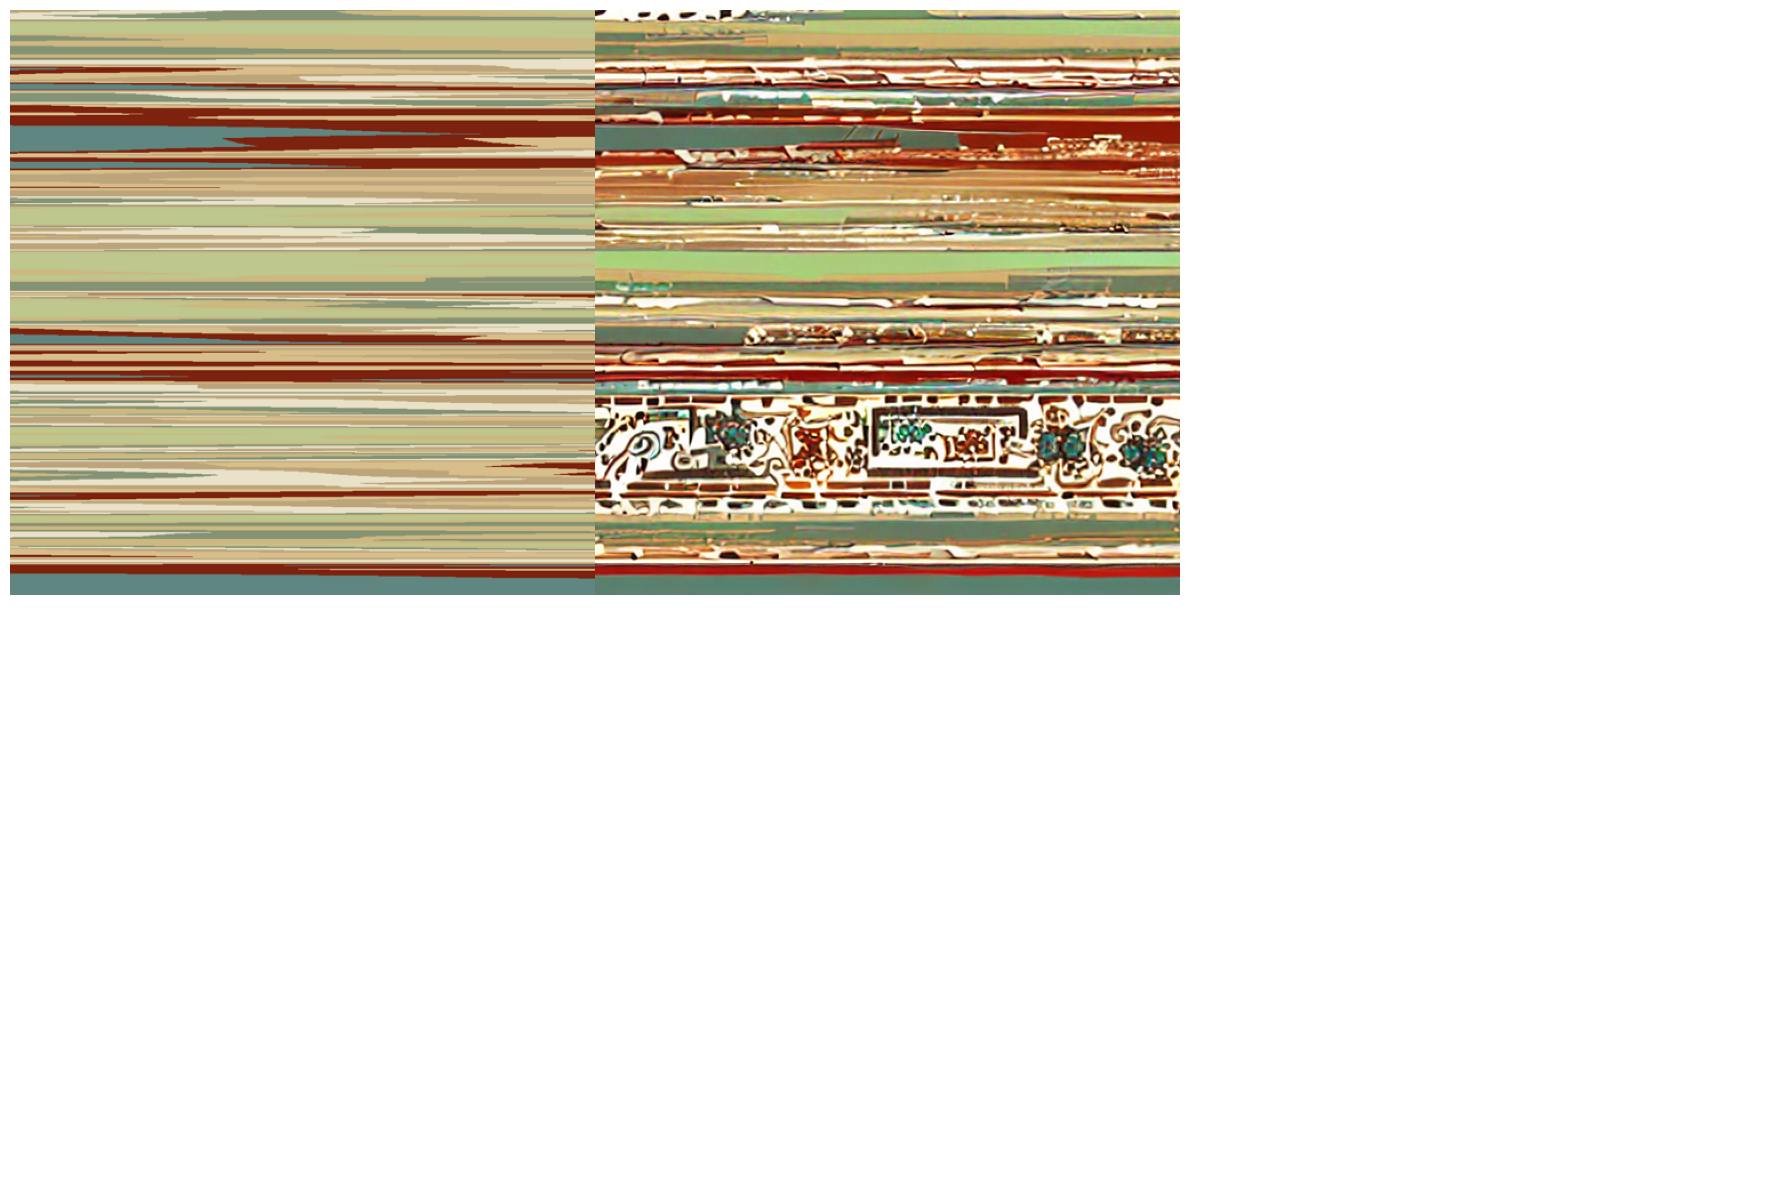

Generating variations for 37.png...


inversion: 100%|██████████| 100/100 [00:11<00:00,  9.05it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

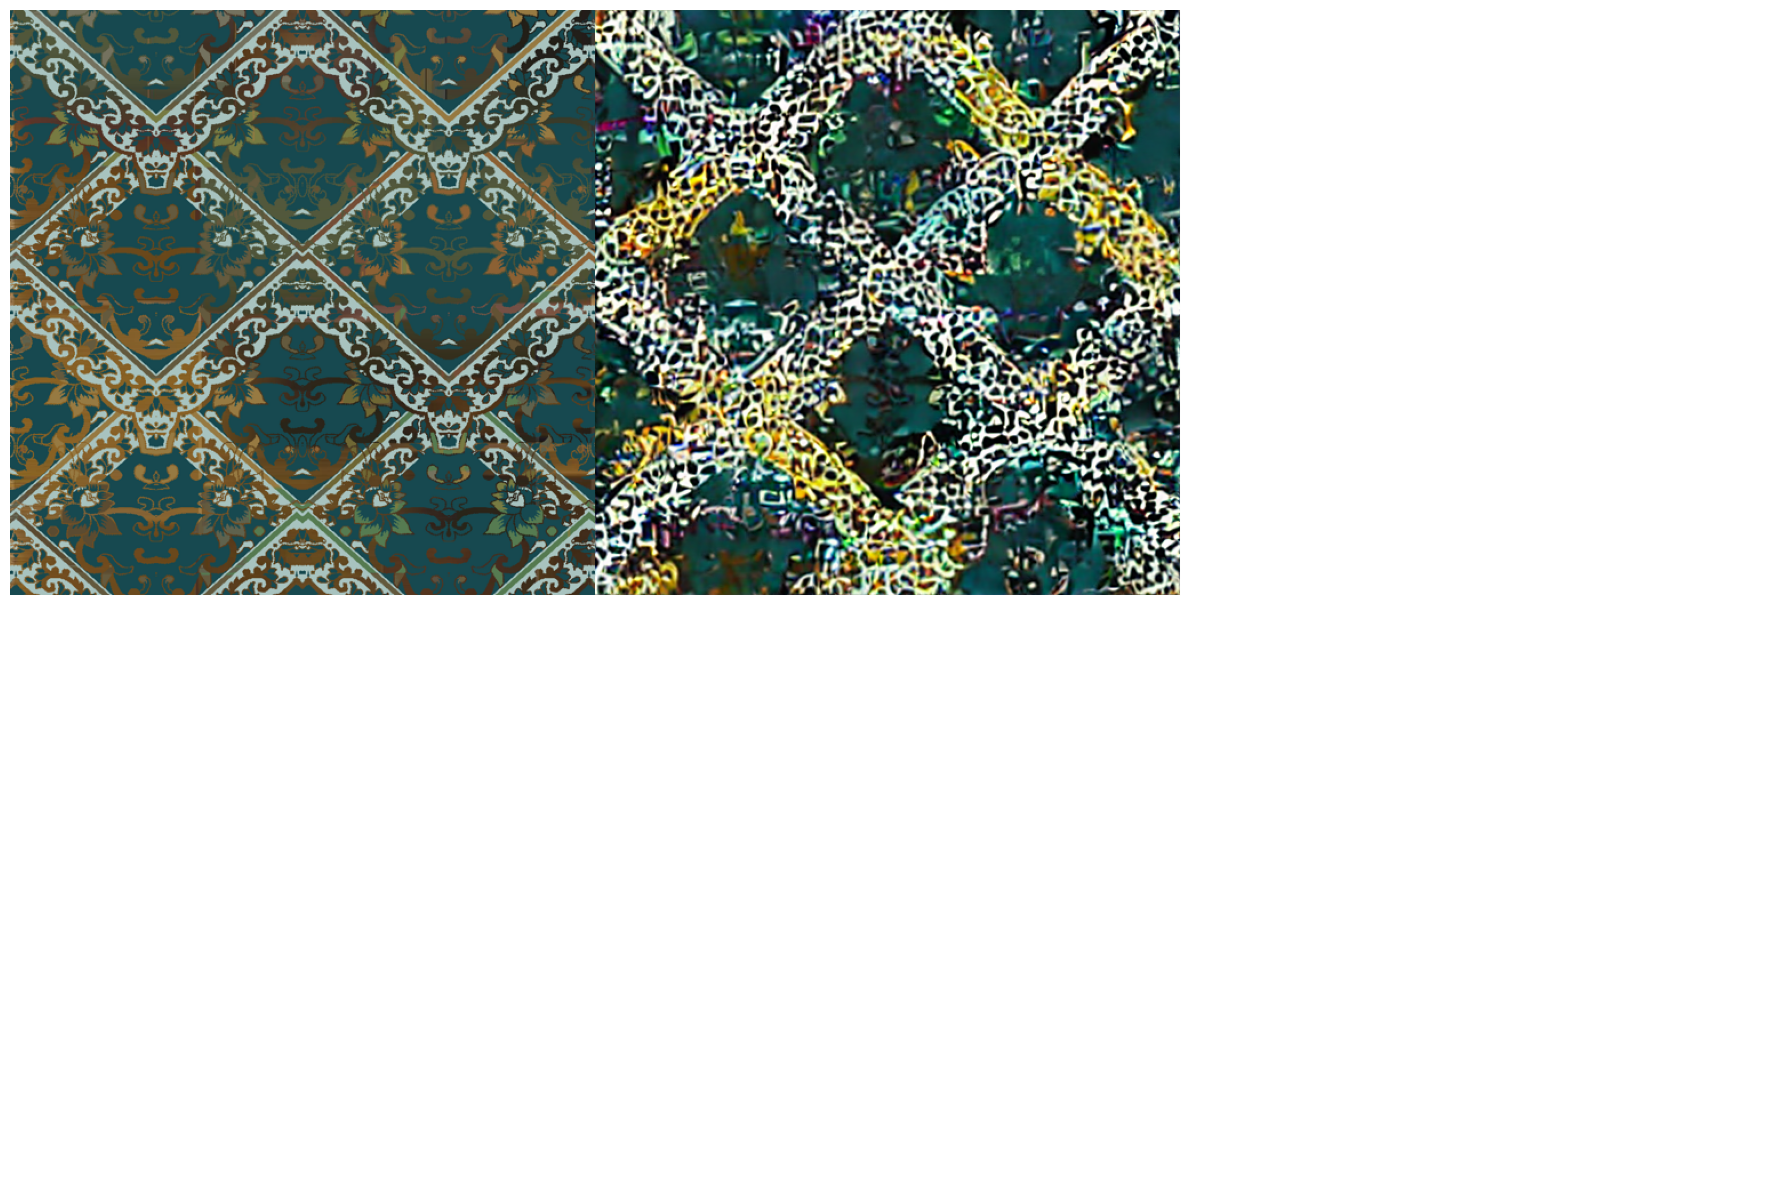

Generating variations for 35.png...


inversion: 100%|██████████| 100/100 [00:11<00:00,  8.98it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import time
input_dir = "/kaggle/input/patternversetest/PatternVerse Test Set - I"  # Replace with actual path
for filename in os.listdir(input_dir):
    if filename.endswith(('.jpg', '.png', '.jpeg')):
            input_path = os.path.join(input_dir, filename)
            print(f"Generating variations for {filename}...")
            generate_carpet_variations(ldm_stable, input_path, output_dir,1)